In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import MultipleLocator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc

In [2]:
# Data Preparation(delete uncertain age data that is <20 and >90)
ages = np.array([24.5, 34.5, 44.5, 54.5, 64.5, 74.5, 84.5])
mean_sbp = np.array([121.27, 123.79, 127.32, 129.98, 132.42, 134.62, 136.89])
mean_dbp = np.array([74.27, 77.31, 79.36, 79.05, 76.71, 74.06, 71.56])

In [3]:
# Model Definitions
def polynomial_model(a, c1, c2, c3):
    return c1 * a**2 + c2 * a + c3

def sigmoid_model(a, s_max, k, a0):
    return s_max / (1 + np.exp(-k * (a - a0)))

def gaussian_model_with_baseline(a, peak_height, a_peak, sigma, baseline):
    return peak_height * np.exp(-((a - a_peak)**2) / (2 * sigma**2)) + baseline

In [4]:
# Polynomial
params_sbp_poly = np.polyfit(ages, mean_sbp, 2)
params_dbp_poly = np.polyfit(ages, mean_dbp, 2)
# Sigmoid & Gaussian
params_sbp_sig, _ = curve_fit(sigmoid_model, ages, mean_sbp, p0=[140, 0.1, 50], maxfev=5000)
s_max_fit, k_fit, a0_fit = params_sbp_sig
params_dbp_gauss, _ = curve_fit(gaussian_model_with_baseline, ages, mean_dbp, p0=[10, 50, 20, 70])
peak_h_fit, a_peak_fit, sigma_fit, baseline_fit = params_dbp_gauss
d_max_fit = peak_h_fit + baseline_fit

In [5]:
def calculate_metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return mse, r_squared

In [6]:
print(f"  SBP: c1 = {params_sbp_poly[0]:.4f}, c2 = {params_sbp_poly[1]:.4f}, c3 = {params_sbp_poly[2]:.4f}")
print(f"  DBP: d1 = {params_dbp_poly[0]:.4f}, d2 = {params_dbp_poly[1]:.4f}, d3 = {params_dbp_poly[2]:.4f}")

  SBP: c1 = -0.0010, c2 = 0.3711, c3 = 112.5885
  DBP: d1 = -0.0066, d2 = 0.6554, d3 = 62.5006


In [7]:
print(f"  SBP (Sigmoid): S_max = {s_max_fit:.4f}, k = {k_fit:.4f}, a0 = {a0_fit:.4f}")
print(f"  DBP (Gaussian): D_max = {d_max_fit:.4f}, a_peak = {a_peak_fit:.4f}, sigma = {sigma_fit:.4f}, baseline = {baseline_fit:.4f}")

  SBP (Sigmoid): S_max = 157.2331, k = 0.0116, a0 = -79.6398
  DBP (Gaussian): D_max = 79.4995, a_peak = 48.7154, sigma = 19.8921, baseline = 69.6415


In [8]:
# Get predictions for each model
sbp_pred_poly = polynomial_model(ages, *params_sbp_poly)
sbp_pred_sig = sigmoid_model(ages, *params_sbp_sig)
dbp_pred_poly = polynomial_model(ages, *params_dbp_poly)
dbp_pred_gauss = gaussian_model_with_baseline(ages, *params_dbp_gauss)

# Calculate metrics
mse_sbp_poly, r2_sbp_poly = calculate_metrics(mean_sbp, sbp_pred_poly)
mse_sbp_sig, r2_sbp_sig = calculate_metrics(mean_sbp, sbp_pred_sig)
mse_dbp_poly, r2_dbp_poly = calculate_metrics(mean_dbp, dbp_pred_poly)
mse_dbp_gauss, r2_dbp_gauss = calculate_metrics(mean_dbp, dbp_pred_gauss)

In [9]:
print("SBP Models:")
print(f"Polynomial: MSE = {mse_sbp_poly:.5f}, R-squared = {r2_sbp_poly:.5f}")
print(f"Sigmoid: MSE = {mse_sbp_sig:.5f}, R-squared = {r2_sbp_sig:.5f}")
print("DBP Models:")
print(f"Polynomial: MSE = {mse_dbp_poly:.5f}, R-squared = {r2_dbp_poly:.5f}")
print(f"Gaussian: MSE = {mse_dbp_gauss:.5f}, R-squared = {r2_dbp_gauss:.5f}")

SBP Models:
Polynomial: MSE = 0.03862, R-squared = 0.99861
Sigmoid: MSE = 0.03884, R-squared = 0.99860
DBP Models:
Polynomial: MSE = 0.32148, R-squared = 0.95432
Gaussian: MSE = 0.00829, R-squared = 0.99882


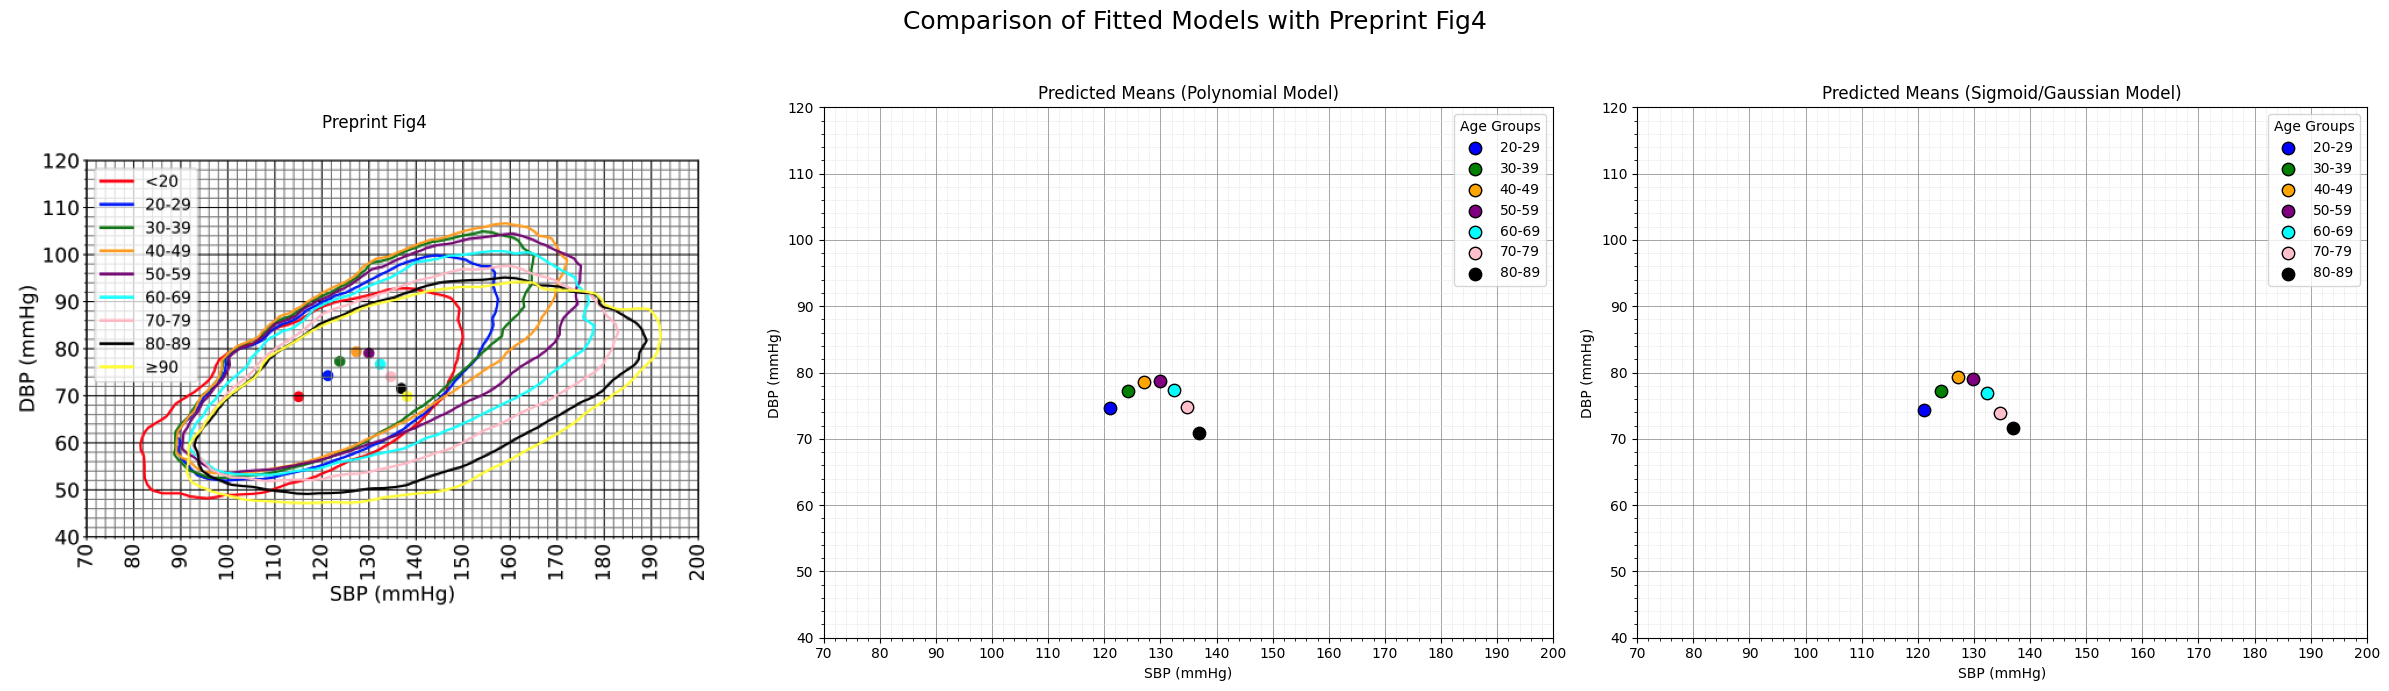

In [10]:
# Compare to preprint figure4
img_path = 'preprint_Fig4.png'
img = mpimg.imread(img_path)

age_labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', ]
age_points_full = np.array([24.5, 34.5, 44.5, 54.5, 64.5, 74.5, 84.5])
colors = ['blue', 'green', 'orange', 'purple', 'cyan', 'pink', 'black']

sbp_pred_poly = polynomial_model(age_points_full, *params_sbp_poly)
dbp_pred_poly = polynomial_model(age_points_full, *params_dbp_poly)
sbp_pred_sig = sigmoid_model(age_points_full, *params_sbp_sig)
dbp_pred_gauss = gaussian_model_with_baseline(age_points_full, *params_dbp_gauss)

fig, axes = plt.subplots(1, 3, figsize=(24, 7), gridspec_kw={'width_ratios': [1, 1, 1]})
fig.suptitle('Comparison of Fitted Models with Preprint Fig4', fontsize=18)

axes[0].imshow(img)
axes[0].set_title('Preprint Fig4')
axes[0].axis('off')

def plot_model_imitation(ax, sbp_points, dbp_points, title):
    ax.set_title(title)
    ax.set_xlabel('SBP (mmHg)')
    ax.set_ylabel('DBP (mmHg)')
    ax.set_xlim(70, 200)
    ax.set_ylim(40, 120)
    ax.minorticks_on()
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.yaxis.set_minor_locator(MultipleLocator(2))
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgray')

    for i in range(len(age_labels)):
        ax.scatter(sbp_points[i], dbp_points[i], s=80, c=colors[i],
                   label=age_labels[i], zorder=5, edgecolors='black')
    ax.legend(title="Age Groups")

plot_model_imitation(axes[1], sbp_pred_poly, dbp_pred_poly, 'Predicted Means (Polynomial Model)')
plot_model_imitation(axes[2], sbp_pred_sig, dbp_pred_gauss, 'Predicted Means (Sigmoid/Gaussian Model)')
plt.tight_layout(rect=[0, 0, 1, 0.95])

In [11]:
# Task B
def generate_synthetic_bp_data(num_males, num_females, random_seed=500):
    np.random.seed(random_seed)
    mean_vec_m = [133.0, 78.8]; cov_m = [[18.6**2, 0.45*18.6*12.6], [0.45*18.6*12.6, 12.6**2]]
    male_data = np.random.multivariate_normal(mean_vec_m, cov_m, num_males)
    df_male = pd.DataFrame(male_data, columns=['SBP', 'DBP']); df_male['sex'] = 1
    mean_vec_f = [125.8, 74.8]; cov_f = [[19.0**2, 0.50*19.0*12.4], [0.50*19.0*12.4, 12.4**2]]
    female_data = np.random.multivariate_normal(mean_vec_f, cov_f, num_females)
    df_female = pd.DataFrame(female_data, columns=['SBP', 'DBP']); df_female['sex'] = 0
    combined_df = pd.concat([df_male, df_female], ignore_index=True)
    return combined_df.sample(frac=1, random_state=random_seed).reset_index(drop=True)

In [12]:
#Trains and evaluates via Regression classifier, with an option for sex bias loss from Lecture11 ppt page24.
def train_and_evaluate_classifier(dataset, use_bias_mitigation=False, lambda_reg=5.0):
    X = dataset[['SBP', 'DBP']]; y = dataset['sex']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=500, stratify=y)

    classifier = LogisticRegression(random_state=500)
    classifier.fit(X_train, y_train)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]

    if not use_bias_mitigation:
        y_pred = (y_pred_proba >= 0.5).astype(int)
    else:
        thresholds = np.linspace(0.01, 0.99, 100)
        best_cost = float('inf')
        best_threshold = 0.5

        is_male_test = (y_test == 1)
        is_female_test = (y_test == 0)

        for t in thresholds:
            current_y_pred = (y_pred_proba >= t).astype(int)
            f_theta = 1 - accuracy_score(y_test, current_y_pred)
            acc_male = accuracy_score(y_test[is_male_test], current_y_pred[is_male_test])
            acc_female = accuracy_score(y_test[is_female_test], current_y_pred[is_female_test])
            phi_theta = abs(acc_male - acc_female)
            cost = f_theta + lambda_reg * phi_theta

            if cost < best_cost:
                best_cost = cost
                best_threshold = t

        print(f"Bias-penalized applied. Optimal threshold found: {best_threshold:.2f} (Cost: {best_cost:.3f})")
        y_pred = (y_pred_proba >= best_threshold).astype(int)

    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'fpr': roc_curve(y_test, y_pred_proba)[0],
        'tpr': roc_curve(y_test, y_pred_proba)[1],
        'roc_auc': auc(*roc_curve(y_test, y_pred_proba)[:2])
    }

In [13]:
def run_experiment(use_mitigation):
    total_samples = 100000
    male_ratios = np.arange(0.1, 1.0, 0.1)
    results, roc_data = [], {}

    mitigation_status = "WITH bias-penalized" if use_mitigation else "WITHOUT bias-penalized"
    print(f" Running Experiment {mitigation_status}")

    for ratio in male_ratios:
        num_males = int(total_samples * ratio)
        num_females = total_samples - num_males
        print(f"  Processing dataset with {ratio*100:.0f}% males...")
        dataset = generate_synthetic_bp_data(num_males, num_females)
        eval_metrics = train_and_evaluate_classifier(dataset, use_bias_mitigation=use_mitigation)
        results.append({'male_ratio': ratio, **eval_metrics})
        roc_data[ratio] = (eval_metrics['fpr'], eval_metrics['tpr'], eval_metrics['roc_auc'])

    return pd.DataFrame(results), roc_data

 Running Experiment WITHOUT bias-penalized
  Processing dataset with 10% males...
  Processing dataset with 20% males...
  Processing dataset with 30% males...
  Processing dataset with 40% males...
  Processing dataset with 50% males...
  Processing dataset with 60% males...
  Processing dataset with 70% males...
  Processing dataset with 80% males...
  Processing dataset with 90% males...
 Running Experiment WITH bias-penalized
  Processing dataset with 10% males...
Bias-penalized applied. Optimal threshold found: 0.10 (Cost: 0.505)
  Processing dataset with 20% males...
Bias-penalized applied. Optimal threshold found: 0.20 (Cost: 0.544)
  Processing dataset with 30% males...
Bias-penalized applied. Optimal threshold found: 0.31 (Cost: 0.608)
  Processing dataset with 40% males...
Bias-penalized applied. Optimal threshold found: 0.40 (Cost: 0.590)
  Processing dataset with 50% males...
Bias-penalized applied. Optimal threshold found: 0.50 (Cost: 0.581)
  Processing dataset with 60% m

(0.0, 1.0)

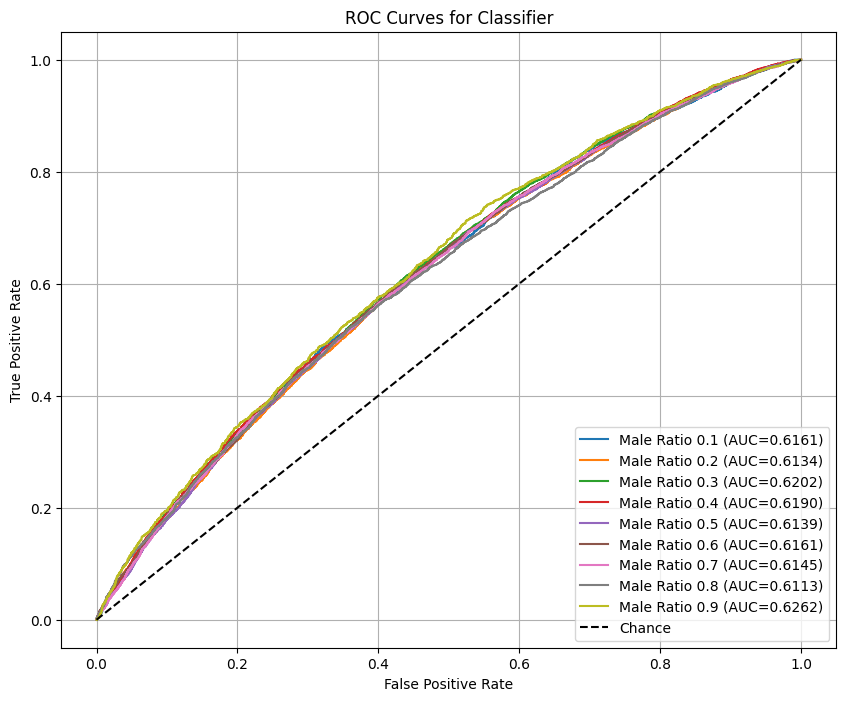

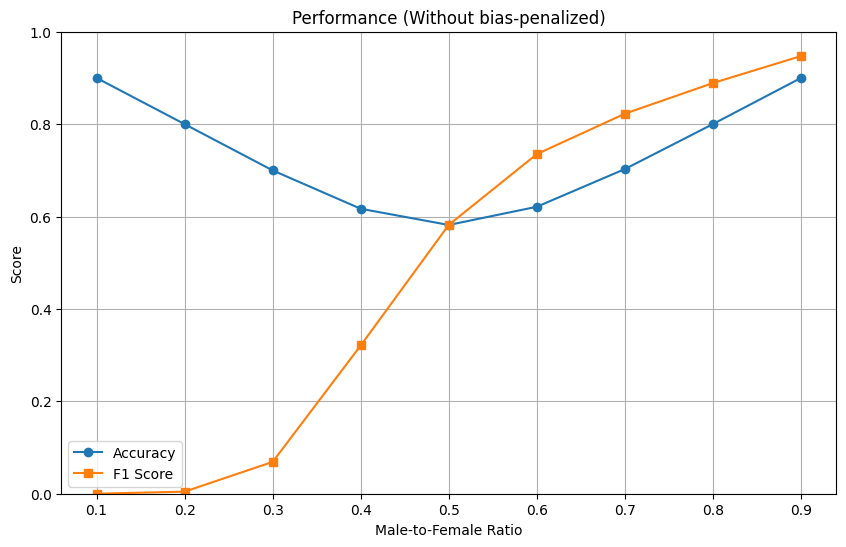

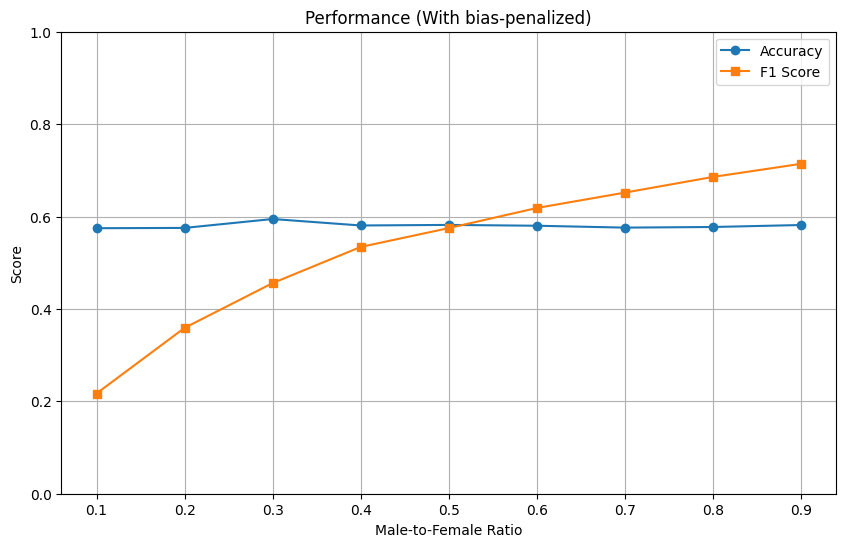

In [14]:
    results_df_no_mitigation, roc_data_no_mitigation = run_experiment(use_mitigation=False)
    results_df_mitigation, roc_data_mitigation = run_experiment(use_mitigation=True)

    plt.figure(figsize=(10, 8))
    for ratio, (fpr, tpr, roc_auc) in roc_data_no_mitigation.items():
        plt.plot(fpr, tpr, label=f'Male Ratio {ratio:.1f} (AUC={roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)

    plt.figure(figsize=(10, 6))
    plt.plot(results_df_no_mitigation['male_ratio'], results_df_no_mitigation['accuracy'], 'o-', label='Accuracy')
    plt.plot(results_df_no_mitigation['male_ratio'], results_df_no_mitigation['f1_score'], 's-', label='F1 Score')
    plt.title('Performance (Without bias-penalized)')
    plt.xlabel('Male-to-Female Ratio')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend()
    plt.ylim(0.0, 1.0)

    plt.figure(figsize=(10, 6))
    plt.plot(results_df_mitigation['male_ratio'], results_df_mitigation['accuracy'], 'o-', label='Accuracy')
    plt.plot(results_df_mitigation['male_ratio'], results_df_mitigation['f1_score'], 's-', label='F1 Score')
    plt.title('Performance (With bias-penalized)')
    plt.xlabel('Male-to-Female Ratio')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend()
    plt.ylim(0.0, 1.0)